## Summary of my analysis of data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
dfs = pd.read_excel('dataset.xlsx', sheetname=None)

Getting a sheet that has all these columns

In [4]:
for v,k in dfs.items():
    if {'id','industry','countryCode','organizationTypeCode','organizationSizeCode','ageRange','gender','scoring'}.issubset(k.columns):
        dataset = k
        break

Filtering the columns

In [5]:
df = dataset[['id','industry', 'countryCode','organizationTypeCode','organizationSizeCode','ageRange','gender','scoring']]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1762 entries, 0 to 1761
Data columns (total 8 columns):
id                      1762 non-null int64
industry                1605 non-null object
countryCode             1611 non-null object
organizationTypeCode    1561 non-null object
organizationSizeCode    1572 non-null object
ageRange                1417 non-null object
gender                  1433 non-null object
scoring                 1466 non-null object
dtypes: int64(1), object(7)
memory usage: 62.0+ KB


In [7]:
df.set_index('id', inplace=True)

Nice way of visualizing the NaN values

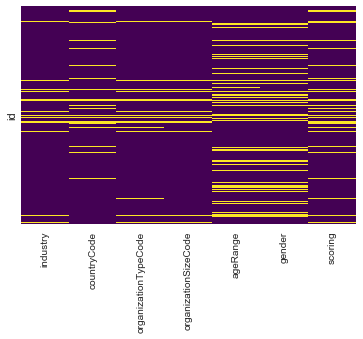

In [8]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

The rows that have a null value on 'scoring' column can be eliminated

In [9]:
df= df[~df['scoring'].isnull()]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1466 entries, 201 to 1961
Data columns (total 7 columns):
industry                1466 non-null object
countryCode             1466 non-null object
organizationTypeCode    1466 non-null object
organizationSizeCode    1466 non-null object
ageRange                1198 non-null object
gender                  1213 non-null object
scoring                 1466 non-null object
dtypes: object(7)
memory usage: 51.5+ KB


In [11]:
df['gender'].isnull().sum()

253

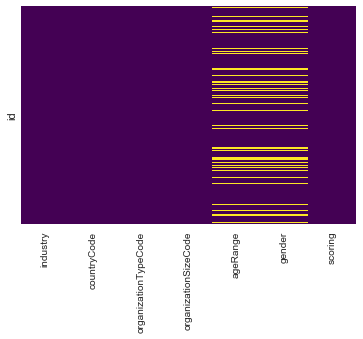

In [12]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

There is a perfect correlation in null values in ageRange and gender, this is my attempt to fill the NaN values(ampute).

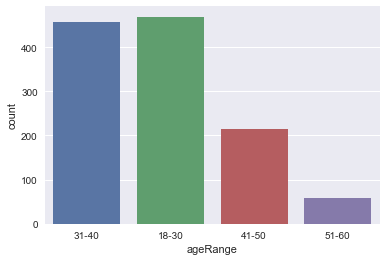

In [13]:
sns.countplot(x='ageRange', data=df)

Males are almost 4 times of females

In [14]:
df['gender'].value_counts()

Male      972
Female    241
Name: gender, dtype: int64

There is a variance in ratio of males to females in different age ranges.

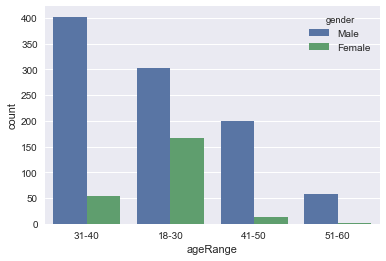

In [15]:
sns.countplot(x='ageRange', data=df, hue='gender')

Here we see a clear pattern, even though males are 4 times of females overall, In some organization size classes females are far more than males.

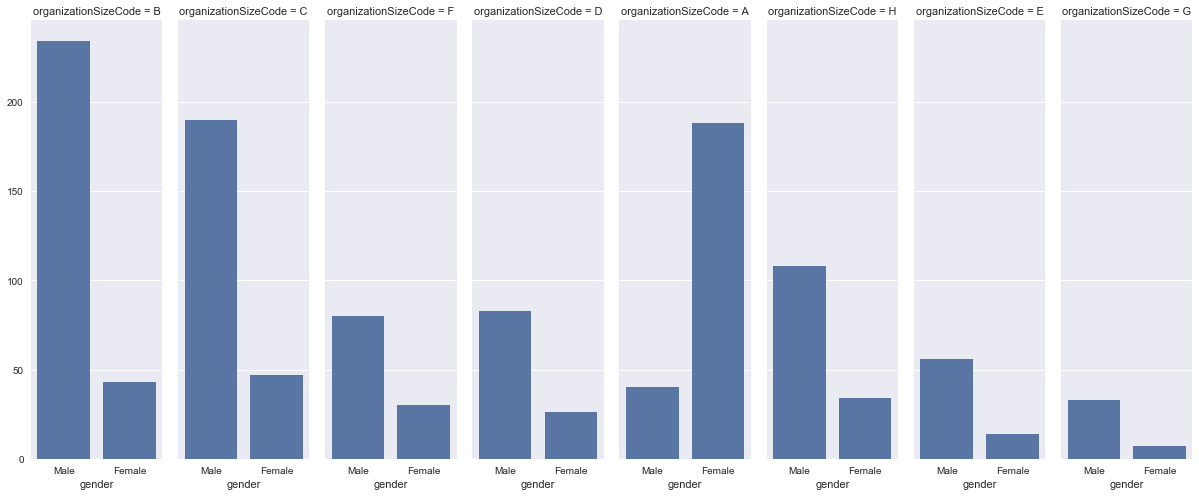

In [16]:
fg = sns.FacetGrid(data=df, col='organizationSizeCode',size=7, aspect=0.3)
fg.map(sns.countplot, 'gender')

Same with organization types, I was hoping that i can fill the null data using these patterns.

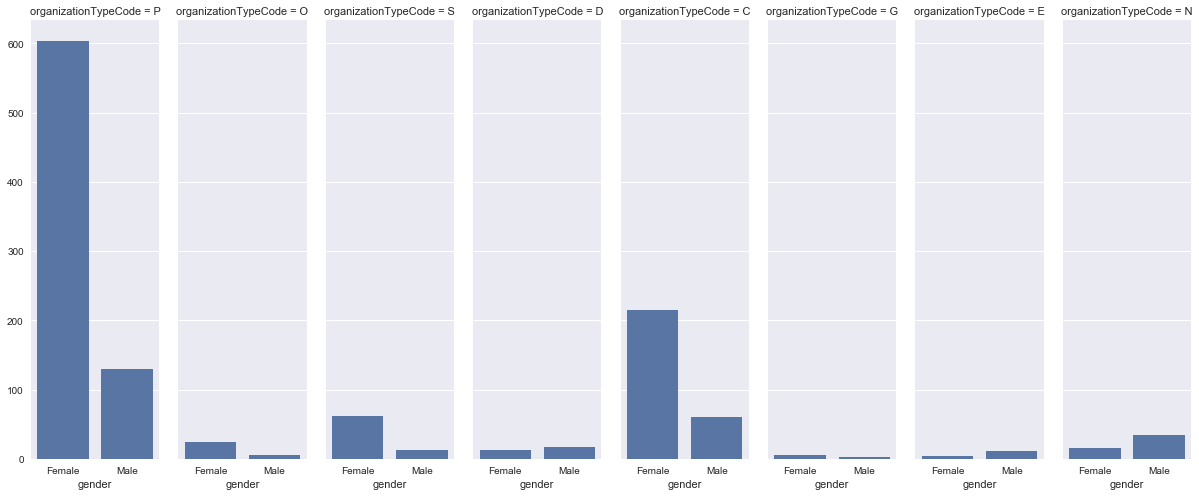

In [17]:
fg = sns.FacetGrid(data=df, col='organizationTypeCode',size=7, aspect=0.3)
fg.map(sns.countplot, 'gender')

How many null values are there for each scenario

In [18]:
mask_sizeA_gendern = (df['organizationSizeCode'] == 'A') & df['gender'].isnull()

In [19]:
mask_sizeA_gendern.sum()

48

In [20]:
df[mask_sizeA_gendern].head()

,industry,countryCode,organizationTypeCode,organizationSizeCode,ageRange,gender,scoring
id,,,,,,,
242,Marketing & Advertising,ES,O,A,NaN,NaN,Loss
315,Online Publishing,NL,P,A,NaN,NaN,Win
317,Internet,US,P,A,NaN,NaN,Win
336,Design,US,S,A,NaN,NaN,Win
369,Sports,US,P,A,NaN,NaN,Win


this graph shows that in these 48 null values(size A, gender null), more than 30 of them are from Organization Type P

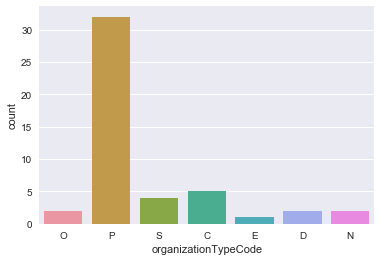

In [21]:
sns.countplot(x='organizationTypeCode', data=df[mask_sizeA_gendern])

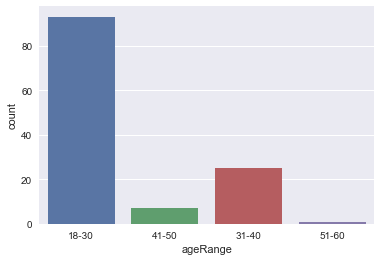

In [22]:
mask_typeP_genderF = (df['organizationTypeCode'] == 'P') &(df['gender'] == 'Female')
sns.countplot(df[mask_typeP_genderF]['ageRange'])

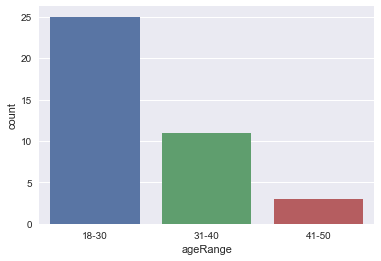

In [23]:
mask_sizeA_genderF = (df['organizationSizeCode'] == 'A') & (df['gender'] == 'Female')
sns.countplot(df[mask_sizeA_genderF]['ageRange'])

These were my last attempts to see if can fill ampute agerange and gender simultaneously

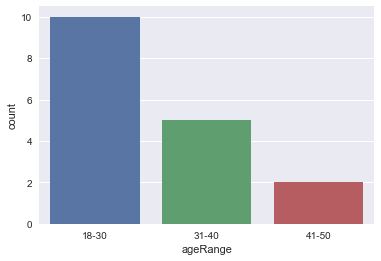

In [24]:
mask_sizeA_typeP_genderF = (df['organizationSizeCode'] == 'A') & (df['organizationTypeCode'] == 'P') & (df['gender'] == 'Female')
sns.countplot(df[mask_sizeA_typeP_genderF]['ageRange'])

I amputed the gender column in hope of getting better results but they were far worse than the situation that I droped all NaN values.

In [25]:
def impute_gender(cols):
    size = cols[0]
    types = cols[1]
    gender = cols[2]
    
    if pd.isnull(gender):
        if size == 'A':
            return 'Female'
        elif types in ['P','S','C']:
            return 'Female'
        else:
            return 'Male'
    else:
        return gender

In [26]:
df = df.copy()

In [27]:
df['gender'] = df[['organizationSizeCode','organizationTypeCode','gender']].apply(impute_gender, axis=1)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1466 entries, 201 to 1961
Data columns (total 7 columns):
industry                1466 non-null object
countryCode             1466 non-null object
organizationTypeCode    1466 non-null object
organizationSizeCode    1466 non-null object
ageRange                1198 non-null object
gender                  1466 non-null object
scoring                 1466 non-null object
dtypes: object(7)
memory usage: 51.5+ KB


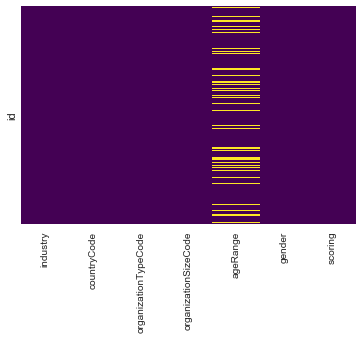

In [29]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

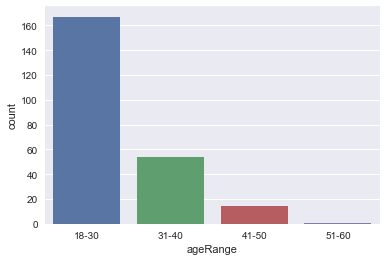

In [30]:
sns.countplot(data=df[df['gender'] == 'Female'], x='ageRange')

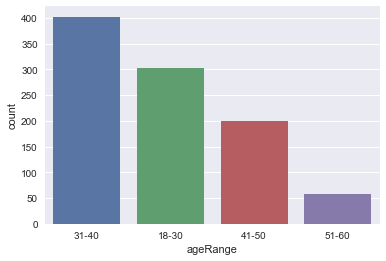

In [31]:
sns.countplot(data=df[df['gender'] == 'Male'], x='ageRange')

Here I gave up on finding the correlations, and decided that droping the all NaN values are good enough for this situation.
One of the solutions that I came up with was to split the data on NaN values on 'gender' and 'ageRange'.
So I can train a model on the data that contains no null in order to predict the null values of 'gender' and 'ageRange', Then concatenate the data back. But i did not attempt this method because I was getting over 93% of accuracy with just droping NaN values.

Resetting everything :(

In [32]:
df = dataset[['id','industry', 'countryCode','organizationTypeCode','organizationSizeCode','ageRange','gender','scoring']]

In [33]:
df.set_index('id', inplace=True)

In [34]:
df = df.dropna()

In [35]:
df.nunique()

industry                114
countryCode              57
organizationTypeCode      8
organizationSizeCode      8
ageRange                  4
gender                    2
scoring                   2
dtype: int64

In [36]:
X = pd.get_dummies(df.drop('scoring', axis=1), drop_first=True)

In [37]:
y = pd.get_dummies(df['scoring'], drop_first=True)

In [38]:
y = y['Win']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=101)

My first choice for the Algorithm was Linear, because the dimension of this data sets is really large, and linear approach tends to get better result on large dimensions

In [90]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)
predictions = logmodel.predict(X_test)

In [91]:
logmodel.score(X_test, y_test)

0.93656093489148584

Even though 94% is a pretty good accuracy, I think there is room for improving.

In [92]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.92      0.80      0.85       139
          1       0.94      0.98      0.96       460

avg / total       0.94      0.94      0.93       599



In [93]:
from scikitplot.metrics import plot_roc_curve

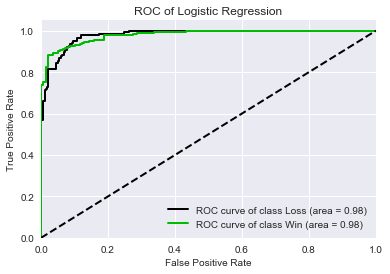

In [94]:
plot_roc_curve(y_test.map({0:'Loss', 1:'Win'}), logmodel.predict_proba(X_test), curves=('each_class'), title="ROC of Logistic Regression")
plt.savefig('LogReg_ROC.png', dpi=300)

For comparing to Logistic Regression QDA and LDA are pretty close algorithms

In [95]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis,LinearDiscriminantAnalysis

In [96]:
QDA = QuadraticDiscriminantAnalysis()
LDA = LinearDiscriminantAnalysis()

This is a common warning for high dimensional and categorical datas, when Variables are almost colinear, the determinant of the matrix becomes really small and close to 0 which decreases the accuracy of the model

In [97]:
qda_prediction = QDA.fit(X_train, y_train).predict(X_test)
lda_prediction = LDA.fit(X_train, y_train).predict(X_test)

c:\users\ardi\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\ardi\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [98]:
print(classification_report(y_test, qda_prediction))

             precision    recall  f1-score   support

          0       0.67      0.37      0.47       139
          1       0.83      0.95      0.89       460

avg / total       0.79      0.81      0.79       599



We see even Discrimination Analysis is not a good choice for this problem, the Linear model out-performs the non_linear

In [99]:
print(classification_report(y_test, lda_prediction))

             precision    recall  f1-score   support

          0       0.76      0.65      0.71       139
          1       0.90      0.94      0.92       460

avg / total       0.87      0.87      0.87       599



 ??

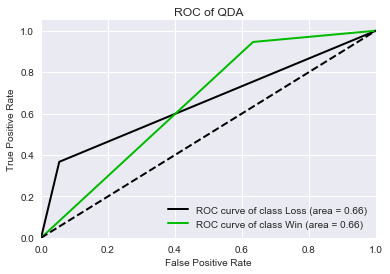

In [100]:
plot_roc_curve(y_test.map({0:'Loss', 1:'Win'}), QDA.predict_proba(X_test), curves=('each_class'), title='ROC of QDA')
plt.savefig('QDA_ROC.png', dpi=300)

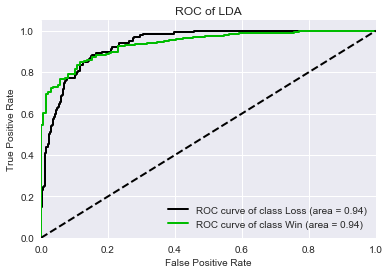

In [101]:
plot_roc_curve(y_test.map({0:'Loss', 1:'Win'}), LDA.predict_proba(X_test), curves=('each_class'), title='ROC of LDA')
plt.savefig('LDA_ROC.png', dpi=300)

I had hopes for KN classifier to out-perform the linear model in categorical datasets but appreantly the dataset can be better classified with linear regression

In [102]:
from sklearn.neighbors import KNeighborsClassifier

In [103]:
knn = KNeighborsClassifier(n_neighbors=12)

In [104]:
knn_prediction = knn.fit(X_train, y_train).predict(X_test)

The prediction did not get better with 'n's greater than 12

In [105]:
print(classification_report(y_test, knn_prediction))

             precision    recall  f1-score   support

          0       0.93      0.20      0.33       139
          1       0.80      1.00      0.89       460

avg / total       0.83      0.81      0.76       599



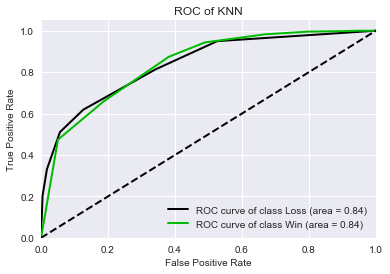

In [106]:
plot_roc_curve(y_test.map({0:'Loss', 1:'Win'}), knn.predict_proba(X_test), curves=('each_class'), title="ROC of KNN")
plt.savefig('KNN_ROC.png', dpi=300)

In [107]:
from sklearn.svm import SVC

In [124]:
linear_svm = SVC(kernel="linear",probability=True)
linsvm_predictions = linear_svm.fit(X_train, y_train).predict(X_test)

In [125]:
print(classification_report(y_test, linsvm_predictions))

             precision    recall  f1-score   support

          0       0.88      0.86      0.87       139
          1       0.96      0.96      0.96       460

avg / total       0.94      0.94      0.94       599



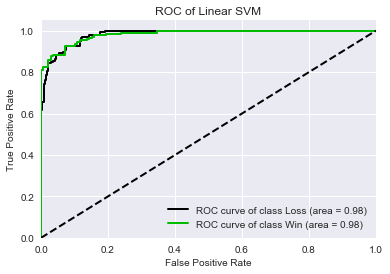

In [126]:
plot_roc_curve(y_test.map({0:'Loss', 1:'Win'}), linear_svm.predict_proba(X_test), curves=('each_class'), title="ROC of Linear SVM")
plt.savefig('linSVM_ROC.png', dpi=300)

In [128]:
svm = SVC(probability=True)
svm_predictions = svm.fit(X_train, y_train).predict(X_test)

In [129]:
print(classification_report(y_test, svm_predictions))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       139
          1       0.77      1.00      0.87       460

avg / total       0.59      0.77      0.67       599



c:\users\ardi\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


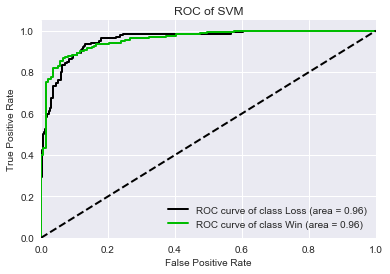

In [130]:
plot_roc_curve(y_test.map({0:'Loss', 1:'Win'}), svm.predict_proba(X_test), curves=('each_class'), title="ROC of SVM")
plt.savefig('SVM_ROC.png', dpi=300)

In [131]:
from sklearn.tree import DecisionTreeClassifier

In [174]:
tree = DecisionTreeClassifier(max_depth=20)
tree_predictions = tree.fit(X_train, y_train).predict(X_test)

In [175]:
print(classification_report(y_test, tree_predictions))

             precision    recall  f1-score   support

          0       0.67      0.58      0.62       139
          1       0.88      0.92      0.90       460

avg / total       0.83      0.84      0.83       599



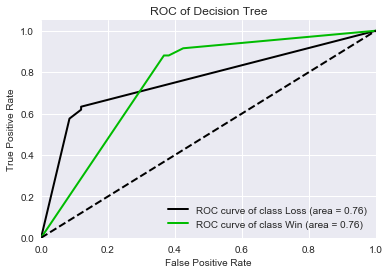

In [176]:
plot_roc_curve(y_test.map({0:'Loss', 1:'Win'}), tree.predict_proba(X_test), curves=('each_class'), title="ROC of Decision Tree")
plt.savefig('TREE_ROC.png', dpi=300)